In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, json, gc, itertools
import time
from datetime import datetime
import joblib
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score


import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# load data
train = pd.read_csv('../input/second_round_training_data.csv')
test = pd.read_csv('../input/second_round_testing_data.csv')

In [3]:
train.head().append(train.tail())

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.167898,104.443982,2.772825,0.146548,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,0.323881,2.597820,41.506485,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,252.483066,0.343232,0.066873,0.002495,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.004594,0.004243,0.135967,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,4.124654,0.170534,0.383800,0.000004,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.031295,0.951186,0.000423,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,294.656750,6.153711,0.014716,4284.326273,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.480634,0.000122,0.000084,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.026284,0.166810,7.587398,0.002202,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,867.342323,0.827308,0.040846,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail
12929,0.047691,4100.626150,206.419171,963.227568,0.027434,0.044685,0.600827,0.118077,887.611257,100.165262,1.028223,4.830450,74.955428,10.634056,0.496456,146.007293,3.193061,0.121117,2.177372,1.253353,Fail
12930,25.364398,8.175837,0.022862,0.145178,3.856009,3.965023,0.600827,17.850021,6.783967,2.705518,10.965784,0.004555,0.002030,0.000047,0.000942,0.006992,0.012377,0.009768,0.031745,0.086606,Pass
12931,0.001252,0.029016,10.955593,1.436280,3.856009,3.262468,0.600827,17.850021,6.783967,2.705518,0.402694,0.000687,208.950511,0.010295,0.080411,0.034142,0.976062,1.111449,0.358124,2.032152,Pass
12932,0.027662,0.118413,554.722425,5.398536,3.454681,7.117767,0.600827,17.850021,6.783967,2.705518,1.514278,0.484542,0.083441,0.008365,0.052951,0.047793,0.452748,0.221144,0.004077,0.197506,Pass
12933,0.000854,68.226467,0.859155,0.424739,6.680183,7.117767,0.152059,6.542504,0.051850,100.165262,13.725377,18.128266,0.008684,19.244706,143.980951,0.039436,26.841978,51.261150,0.266178,9.168458,Good


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Parameter1     12934 non-null  float64
 1   Parameter2     12934 non-null  float64
 2   Parameter3     12934 non-null  float64
 3   Parameter4     12934 non-null  float64
 4   Parameter5     12934 non-null  float64
 5   Parameter6     12934 non-null  float64
 6   Parameter7     12934 non-null  float64
 7   Parameter8     12934 non-null  float64
 8   Parameter9     12934 non-null  float64
 9   Parameter10    12934 non-null  float64
 10  Attribute1     12934 non-null  float64
 11  Attribute2     12934 non-null  float64
 12  Attribute3     12934 non-null  float64
 13  Attribute4     12934 non-null  float64
 14  Attribute5     12934 non-null  float64
 15  Attribute6     12934 non-null  float64
 16  Attribute7     12934 non-null  float64
 17  Attribute8     12934 non-null  float64
 18  Attrib

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Parameter1,12934.0,1.774683e+04,4.487178e+05,1.495298e-08,0.034852,0.914832,26.807664,3.721082e+07
Parameter2,12934.0,2.779988e+02,7.586231e+03,7.474579e-06,0.100327,0.987826,9.316492,5.677669e+05
Parameter3,12934.0,5.490399e+02,1.437610e+04,2.336221e-06,0.085906,0.958922,11.040434,9.040502e+05
Parameter4,12934.0,8.946703e+05,5.139356e+07,2.229685e-10,0.019970,0.998327,48.809639,5.462996e+09
Parameter5,12934.0,5.263298e+00,7.572463e+00,9.985942e-07,0.827784,2.484379,6.680183,8.367195e+01
Parameter6,12934.0,5.385724e+00,7.128595e+00,5.465098e-07,0.464037,2.684398,7.117767,4.117541e+01
Parameter7,12934.0,2.575758e+02,1.976065e+03,6.238222e-04,0.152059,0.600827,2.374035,3.569859e+04
Parameter8,12934.0,4.454253e+01,1.128774e+03,1.586264e-02,0.035407,2.931083,17.850021,6.698472e+04
Parameter9,12934.0,4.080924e+04,2.646957e+06,3.962831e-04,0.593081,0.593081,6.783967,1.738083e+08
Parameter10,12934.0,3.137588e+01,1.519688e+02,1.023626e-03,0.073078,0.727611,10.060093,1.378908e+04


In [6]:
train.nunique().sort_values(ascending=False)

Attribute1       12934
Attribute3       12934
Parameter2       12934
Parameter3       12934
Parameter4       12934
Attribute2       12934
Parameter1       12934
Attribute7         799
Attribute9         726
Attribute4         682
Attribute10        665
Attribute8         660
Attribute5         640
Attribute6         427
Parameter5         139
Parameter6          83
Parameter10         42
Parameter8          26
Parameter9          17
Parameter7          15
Quality_label        4
dtype: int64

In [7]:
# target 编码
train['Quality_label'] = train['Quality_label'].astype("category").cat.set_categories(["Fail", "Pass", "Good", "Excellent"]).cat.codes

In [8]:
test.head().append(test.tail())

,Group,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0,2.167762,10.060093,0.035811,0.459938,7.460600,17.962176,18.872982,0.152059,0.035407,0.593081
1,0,0.006197,0.052625,0.047829,0.322457,0.207077,0.664442,0.314162,0.038483,17.850021,0.593081
2,0,1.179951,0.052625,0.075537,26.113194,0.304415,0.664442,0.258497,0.038483,17.850021,0.593081
3,0,0.007218,1.010385,5.081092,1.132919,931.721241,2.225808,2.208755,0.038483,2.931083,NaN
4,0,3.355337,0.377332,0.076572,23.199547,1.172201,3.095123,2.684398,0.038483,2.931083,NaN
5995,119,0.002523,0.037897,0.382451,2.726780,0.052325,8.322398,5.856584,0.600827,17.850021,6.783967
5996,119,2.562644,0.727611,1.925763,0.189935,2.583829,14.417794,5.856584,0.152059,2.931083,262.444835
5997,119,0.008409,0.073078,5.933060,1.164766,0.112947,3.454681,3.262468,0.152059,6.542504,0.051850
5998,119,0.248161,1.403055,1.757524,0.307520,106.083007,4.803947,3.965023,0.152059,2.931083,NaN
5999,119,1548.742042,0.073078,1.629426,165.480669,0.055586,3.454681,3.262468,0.600827,21.818138,NaN


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Group        6000 non-null   int64  
 1   Parameter1   6000 non-null   float64
 2   Parameter10  6000 non-null   float64
 3   Parameter2   6000 non-null   float64
 4   Parameter3   6000 non-null   float64
 5   Parameter4   6000 non-null   float64
 6   Parameter5   6000 non-null   float64
 7   Parameter6   6000 non-null   float64
 8   Parameter7   6000 non-null   float64
 9   Parameter8   6000 non-null   float64
 10  Parameter9   3000 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 515.8 KB


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Group,6000.0,59.500000,3.464270e+01,0.000000e+00,29.750000,59.500000,89.250000,1.190000e+02
Parameter1,6000.0,8265.657910,2.487136e+05,8.420902e-08,0.074000,0.998881,11.953551,1.396008e+07
Parameter10,6000.0,43.034446,2.113356e+02,1.023626e-03,0.101478,1.403055,13.969790,1.378908e+04
Parameter2,6000.0,126.223368,1.738768e+03,2.077855e-05,0.117208,0.997680,9.050826,9.236684e+04
Parameter3,6000.0,2994.860356,8.078260e+04,4.036410e-08,0.070702,0.944933,14.951376,5.027128e+06
Parameter4,6000.0,121245.318246,5.416637e+06,2.491622e-08,0.052761,0.958912,15.842870,4.019258e+08
Parameter5,6000.0,6.937771,9.921864e+00,2.155259e-06,0.923947,2.484379,7.456215,8.367195e+01
Parameter6,6000.0,6.559966,8.560064e+00,5.067729e-09,0.685412,3.262468,8.650538,4.117541e+01
Parameter7,6000.0,184.351056,1.333058e+03,6.238222e-04,0.152059,0.600827,2.374035,3.569859e+04
Parameter8,6000.0,43.946117,1.279488e+03,1.586264e-02,0.035407,2.931083,17.850021,6.698472e+04


In [11]:
test.nunique().sort_values(ascending=False)

Parameter4     5657
Parameter3     5657
Parameter2     5657
Parameter1     5657
Parameter5      130
Group           120
Parameter6       79
Parameter10      42
Parameter8       23
Parameter7       15
Parameter9       14
dtype: int64

In [12]:
train.corr()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
Parameter1,1.000000,-0.000755,-0.001305,-0.000668,0.023519,0.006494,-0.001044,-0.001155,-0.000608,0.006845,-0.001165,-0.000963,-0.000513,-0.000655,-0.000351,-0.000477,-0.000385,-0.000386,-0.000406,-0.000503,-0.012531
Parameter2,-0.000755,1.000000,-0.000610,-0.000366,-0.002502,-0.002055,-0.001987,-0.000841,-0.000364,-0.000296,0.000202,-0.000578,0.000601,-0.000586,-0.000321,-0.000447,-0.000329,-0.000328,-0.000286,-0.000457,-0.002605
Parameter3,-0.001305,-0.000610,1.000000,-0.000633,0.002709,0.002053,-0.003771,-0.000246,-0.000583,-0.004134,-0.000766,-0.000922,-0.000525,-0.000610,-0.000340,-0.000462,-0.000370,-0.000368,-0.000400,-0.000452,-0.014082
Parameter4,-0.000668,-0.000366,-0.000633,1.000000,-0.006002,-0.005001,0.003094,-0.000616,-0.000265,0.000947,0.000979,-0.000432,-0.000082,-0.000286,-0.000155,-0.000170,-0.000169,-0.000170,-0.000214,-0.000222,0.002722
Parameter5,0.023519,-0.002502,0.002709,-0.006002,1.000000,0.824899,-0.090214,-0.022421,-0.010680,-0.002026,-0.001530,-0.008875,0.013970,-0.008295,-0.002154,-0.008326,-0.005228,-0.005324,0.000493,-0.006286,-0.042020
Parameter6,0.006494,-0.002055,0.002053,-0.005001,0.824899,1.000000,-0.098085,-0.025442,-0.011641,-0.030657,0.003099,-0.006902,0.027203,-0.006182,-0.004449,-0.008906,-0.004245,-0.004485,-0.004844,-0.008345,-0.052075
Parameter7,-0.001044,-0.001987,-0.003771,0.003094,-0.090214,-0.098085,1.000000,0.003589,0.044420,0.089863,-0.003190,0.000209,-0.001192,-0.001882,-0.001156,0.003746,-0.001214,-0.001180,-0.001601,-0.001045,-0.060555
Parameter8,-0.001155,-0.000841,-0.000246,-0.000616,-0.022421,-0.025442,0.003589,1.000000,-0.000471,-0.007620,-0.001030,-0.000884,-0.000519,-0.000432,-0.000210,-0.000489,-0.000235,-0.000231,-0.000091,-0.000431,-0.023650
Parameter9,-0.000608,-0.000364,-0.000583,-0.000265,-0.010680,-0.011641,0.044420,-0.000471,1.000000,-0.000580,-0.000505,-0.000376,-0.000217,0.000162,-0.000137,0.006174,-0.000150,-0.000151,-0.000162,-0.000197,-0.018715
Parameter10,0.006845,-0.000296,-0.004134,0.000947,-0.002026,-0.030657,0.089863,-0.007620,-0.000580,1.000000,-0.004728,-0.001184,-0.001943,-0.003334,0.028359,-0.001812,-0.002009,-0.002017,-0.002507,-0.002585,-0.024237


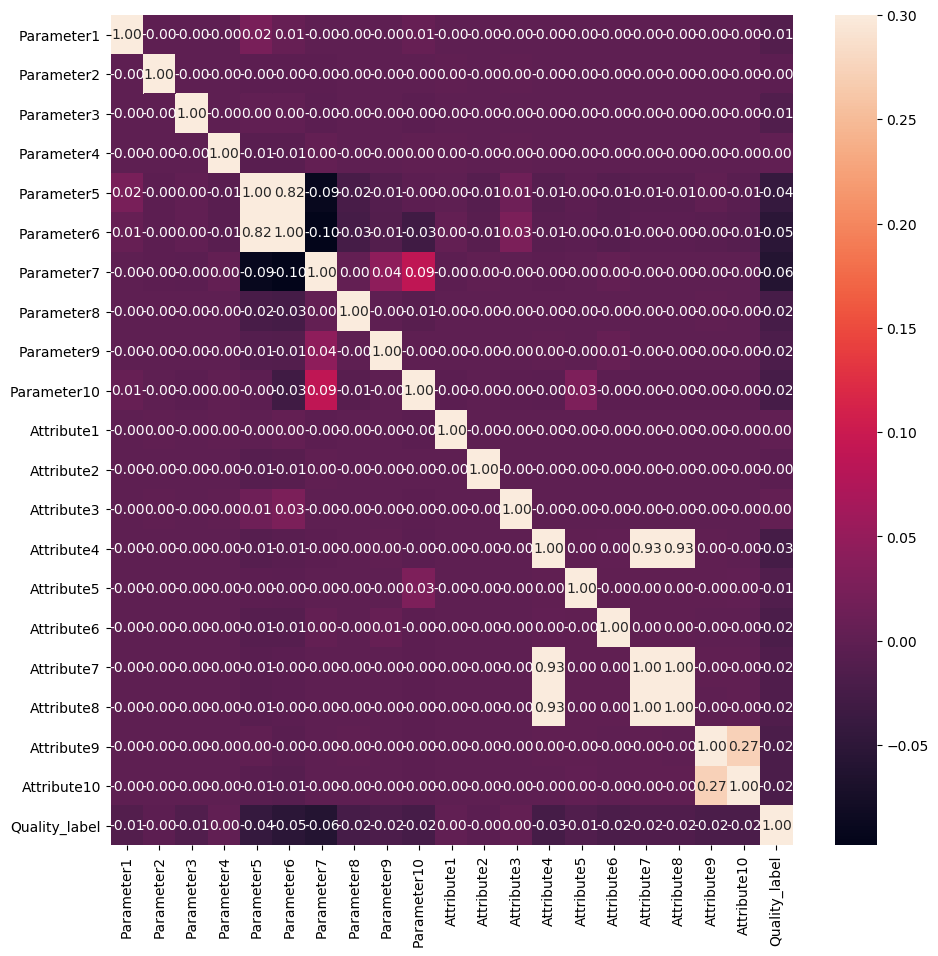

In [13]:
plt.figure(figsize=(11, 11),dpi=100)
corrmat = train.corr()
sns.heatmap(corrmat,
            vmax=0.3, 
            annot=True,#图中数字文本显示
            fmt=".2f",#格式化输出图中数字，即保留小数位数等          
           )

# 预处理

In [14]:
# train 分离 target
target = train.pop('Quality_label')
target.unique()

array([1, 0, 2, 3], dtype=int8)

In [16]:
# train 分离 parameter 和 attribute
# train只包含p系列特征
col_attr = ['Attribute{}'.format(x) for x in range(1,11)]
attr = train[col_attr]
train = train.drop(columns=col_attr)

In [18]:
# test 分离 group
group = test.pop('Group')
group = group.rename('group')

In [19]:
# 简化列名
colnames = ['p{}'.format(i) for i in range(1,11)]
train.columns = colnames
test.columns = colnames

colnames = ['a{}'.format(i) for i in range(1,11)]
attr.columns = colnames

# 特征工程

In [21]:
# rounding
round_fmt = {1: 11, 2: 11, 3: 11, 4: 11, 5: 8,
             6: 8, 7: 8, 8: 8, 9: 8, 10: 8}
for i, r in round_fmt.items():
    train['p{}'.format(i)] = train['p{}'.format(i)].round(r)
    test['p{}'.format(i)] = test['p{}'.format(i)].round(r)

In [22]:
# transform log2
# 对数转换和归一化后存在负数，影响加减乘除的结果
# 需要测试对数转换前的效果
train = train.apply(np.log2)
attr = attr.apply(np.log2)
test = test.apply(np.log2)

In [23]:
# 删除 p1-p4，保留 p5-p10
train.drop(columns=['p{}'.format(i) for i in range(1, 5)], inplace=True)
test.drop(columns=['p{}'.format(i) for i in range(1, 5)], inplace=True)
gc.collect()

14987

In [24]:
print(train.shape, test.shape)

(12934, 6) (6000, 6)


# predict a4-a6 and p9
## p9
p9特征：train中只有17个不同的取值，test中只有14个不同的取值，是一个类别特征

In [25]:
train['p9'].unique()

array([ -0.75369838,  -4.26952583,   6.27795664,   2.76212913,
        -7.78535313,   9.79378415, -11.30119222,   8.0358704 ,
         1.00421537,   4.52004288,  12.25486341,  16.82543918,
        14.01277717,  27.37292172,  13.30961167,  20.3412667 ,
        11.55169791])

In [26]:
test['p9'].unique()

array([-4.81981465,  4.1578539 ,  1.55143401,  3.86825169, -3.08220134,
        2.70984285, -3.66140576, -5.97822329,  4.44745611, -1.34458808,
        3.28904727,  6.18506937, 10.2395003 , -4.24061029, 14.29393124,
        7.92268262,  7.34347821, 16.0315445 , -2.5029969 , -5.39901905,
        2.13063843,  9.08109146,  0.39302518])

In [ ]:
test['p9_isnull'] = test['p9'].isnull()
test_notnull = test.loc[test['p9'].notnull(), :]

lbl = LabelEncoder()
lbl.fit(list(test_notnull['p9']) + list(train['p9']))
test_notnull['p9'] = lbl.transform(test_notnull['p9'])
train['p9'] = lbl.transform(train['p9'])
test.loc[test['p9_isnull'] == False, 'p9'] = test_notnull
del test_notnull